In [1]:
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import backend
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
BATCH_SIZE = 4
IMG_SIZE = (160, 160)

train_dir = "archive/Train"
test_dir = "archive/mytest"

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE, 
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  seed = 42,
                                                  validation_split = 0.2,
                                                  subset = 'validation',
                                                  image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 39209 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.
Using 2526 files for validation.
Found 12630 files belonging to 43 classes.


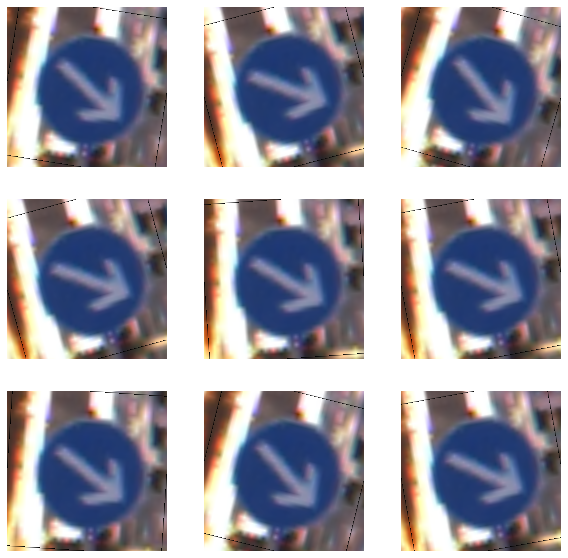

In [4]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
])
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

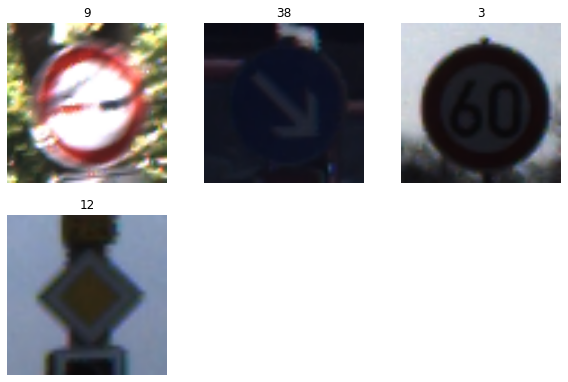

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(4, 5, 5, 512)


In [6]:
#model = keras.models.load_model('my_model4.h5')

In [5]:
#base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [6]:
try:
    model = tf.keras.models.load_model('my_model5.h5')
except:
    inputs = tf.keras.Input(shape=(160, 160, 3))
    #x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = base_model(x, training=True)
    x = keras.layers.Dropout(rate=0.25)(x)
    x = Flatten()(x)
    x = Dense(units=4096,activation="relu")(x)
    x = Dense(units=4096,activation="relu")(x)
    x = keras.layers.Dropout(rate=0.5)(x)
    outputs = Dense(units=43)(x)
    model = tf.keras.Model(inputs, outputs)

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)             

In [9]:
hist = model.fit(x=train_dataset, epochs=5, validation_data = validation_dataset)
model.save('my_model5.h5') 

Epoch 1/5
9803/9803 [==============================] - 1402s 143ms/step - loss: 0.9275 - accuracy: 0.7358 - val_loss: 0.1607 - val_accuracy: 0.9600
Epoch 2/5
9803/9803 [==============================] - 1392s 142ms/step - loss: 0.1618 - accuracy: 0.9631 - val_loss: 0.2248 - val_accuracy: 0.9545
Epoch 3/5
9803/9803 [==============================] - 1415s 144ms/step - loss: 0.1281 - accuracy: 0.9743 - val_loss: 0.1875 - val_accuracy: 0.9481
Epoch 4/5
9803/9803 [==============================] - 1417s 145ms/step - loss: 0.1132 - accuracy: 0.9794 - val_loss: 0.1735 - val_accuracy: 0.9719
Epoch 5/5
9803/9803 [==============================] - 1415s 144ms/step - loss: 0.1154 - accuracy: 0.9809 - val_loss: 0.1704 - val_accuracy: 0.9719


In [10]:
model.evaluate(x = test_dataset)

3158/3158 [==============================] - 209s 66ms/step - loss: 0.1827 - accuracy: 0.9690


[0.18266165256500244, 0.9689627885818481]

In [12]:
for name in class_names:
    print(name)

0
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
33
34
35
36
37
38
39
4
40
41
42
5
6
7
8
9


In [4]:
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [10]:
img = keras.preprocessing.image.load_img(
    "9-11897.png", target_size=(160, 160)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(np.argmax(score))
print(100*score[np.argmax(score)])

7
tf.Tensor(25.149961, shape=(), dtype=float32)


In [ ]:
direct = 'archive/mytest'
for folder in os.listdir(direct):
    for name in os.listdir(direct+'/'+folder):
        img = keras.preprocessing.image.load_img(direct+'/'+folder + '/'+str(name), target_size=(160, 160))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        if np.argmax(score) == int(folder) and score[np.argmax(score)] > 0.9:
            print(np.argmax(score))
            print(100*score[np.argmax(score)])
            print(name)
            break

In [13]:
np.save('newVGG.npy',model.weights)

In [14]:
data_dict2 = np.load('newVGG.npy', encoding='latin1', allow_pickle=True)
a = list(data_dict2)
my_dict = {}
for var1, var2 in zip(*[iter(a)]*2):
    name = var1.name
    bc, _ = name.split("/")
    b = []
    b.append(var1.numpy())
    b.append(var2.numpy())
    my_dict[bc] = b
np.save('f2vgg16.npy', my_dict)